In [1]:
import numpy as np
import random
from platypus import Hypervolume, display, calculate, CMAES, MOEAD, NSGAII, NSGAIII, SPEA2, IBEA, Problem, Real
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from datetime import datetime

In [2]:
from load_data import *
from bias_functions import *
from utility_functions import *

In [3]:
def getDataset(setSelection):
    if setSelection == 'toy':
        X,y = generate_toy_data(1000,200,2)
    elif setSelection == 'adult':
        protectedAttributes={'race':'White','gender':'Male'}
        X,y = load_adult(protectedAttributes=protectedAttributes)
    elif setSelection == 'bank':
        X,y = load_bank()
    elif setSelection == 'german':
        X,y = load_german()
    elif setSelection == 'mortgage':
        protectedCategoricalAttributes={'applicant_ethnicity_name':'Not Hispanic or Latino',
                                'applicant_race_name_1':'White','applicant_sex_name':'Male'}
        protectedNumericalAttributes=['minority_population']
        X,y = load_mortgage(protectedCategoricalAttributes=protectedCategoricalAttributes, \
                            protectedNumericalAttributes=protectedNumericalAttributes)
    else:
        print('dataset not recognised')
        
    X = np.hstack([X, np.ones((X.shape[0],1))]) ## add ones to solve for affine functions
    
    return X,y

In [4]:
# new problems

# problem 7: datasets {Mortgage} and {gender,race}
# objectives: FPR, FNR, DI across 2 attributes

def problem7_base(w,X,y,sensitiveAttributeIndex1,sensitiveAttributeIndex2):
    FPRobjective = FPRcompute(w,X,y)
    FNRobjective = FNRcompute(w,X,y)
    fairnessObjective1 = differenceDisparateMistreatment(w,X,y,sensitiveAttributeIndex=sensitiveAttributeIndex1,type='OMR')
    fairnessObjective2 = differenceDisparateMistreatment(w,X,y,sensitiveAttributeIndex=sensitiveAttributeIndex2,type='OMR')
    return FPRobjective, FNRobjective, np.abs(fairnessObjective1[0]-fairnessObjective1[1]),np.abs(fairnessObjective2[0]-fairnessObjective2[1])

def problem7_train(w):
    return problem7_base(w,trainxs,trainys,sensitiveAttributeIndex1=sensitiveAttributeIndex1,sensitiveAttributeIndex2=sensitiveAttributeIndex2)
def problem7_test(w):
    return problem7_base(w,testxs,testys,sensitiveAttributeIndex1=sensitiveAttributeIndex1,sensitiveAttributeIndex2=sensitiveAttributeIndex2)

## Sensitive attributes list:

adult: 8 - race, 9 - gender ;  variables = 15 ; 45222 samples

bank: 0 - age ; variables = 21 ; 41188 samples

german: 6 - gender, 9 - age, 14 - foreign worker ; variables = 25 ; 1000 samples

mortgage: 12 - ethnicity, 14 - race, 16 - gender, 24 - minority population ; variables = 30 ; 200000 samples

In [85]:
now = datetime.now()

# these lines define the problem, test problem, dataset, algorithm and number of sampling runs
noOfObjectives = 4

dataset = 'adult'

if dataset == 'adult':
    sensitiveAttributeIndex1 = 9
    sensitiveAttributeIndex2 = 8
    noOfVariables = 15
elif dataset == 'german':
    sensitiveAttributeIndex1 = 9
    sensitiveAttributeIndex2 = 6
    noOfVariables = 25
else:
    sensitiveAttributeIndex1 = 16
    sensitiveAttributeIndex2 = 14
    noOfVariables = 30
    
problem = Problem(noOfVariables,noOfObjectives)
problem.function = problem7_train

testProblem = Problem(noOfVariables,noOfObjectives)
testProblem.function = problem7_test



noOfSamplingRuns = 20

X,y = getDataset(dataset)

problem.types[:] = Real(-5,5)

hypervolumeArray = np.zeros((noOfSamplingRuns, 2)) # col 0 for training results (hypervolume), col 1 for test results
extremesArray = np.zeros((2, noOfObjectives, noOfObjectives, noOfSamplingRuns)) # the first dimension is for train/test
averagePointArray = np.zeros((2, noOfSamplingRuns, noOfObjectives)) # the first dimension is for train/test. This array holds the average objective point for each run
trainingAlgoDict = {}
datasetDict = {}

# these will be used to store the algorithm that returns the largest hypervolume
bestTrainAlgorithm = None
bestTrainHypervolume = 0
bestTestAlgorithm = None
bestTestHypervolume = 0
totalTrainTime = 0
totalTestTime = 0

for run in range(noOfSamplingRuns):

    # generate new train/test split for each run
    trainxs, testxs, trainys, testys  = train_test_split(X,y,train_size=0.8)  
    
    # training run
    startTime = time.perf_counter()
    
    trainAlgorithm = NSGAII(problem,population_size=500)
    trainAlgorithm.run(10000)

    trainingAlgoDict[run] = trainAlgorithm
    datasetDict[run] = [trainxs, testxs, trainys, testys]
    
    trainHyp = Hypervolume(minimum=[0]*noOfObjectives,maximum=[1]*noOfObjectives)
    trainHypResult = trainHyp(trainAlgorithm.result)  
    hypervolumeArray[run, 0] = trainHypResult
    
    singleRunExtremesArray, averagePoint = findExtremes_averagePoint(trainAlgorithm)
    extremesArray[0,:,:,run] = singleRunExtremesArray
    averagePointArray[0,run,:] = averagePoint
    
    endTime = time.perf_counter()
    trainTime = endTime - startTime
    totalTrainTime += trainTime
    
    print("{}: training took {:.2f} seconds w/ hypervolume {:2f}".format(run, trainTime, trainHypResult))
    
    
    # test run (not used)

    startTime = time.perf_counter()
       
    endTime = time.perf_counter()
    testTime = endTime - startTime
    totalTestTime += testTime

    print("{}: testing took {:.2f} seconds w/ hypervolume {:2f}".format(run, testTime, testHypResult))
    
    if trainHypResult > bestTrainHypervolume:
        bestTrainHypervolume = trainHypResult
        bestTrainAlgorithm = deepcopy(trainAlgorithm)
        
        bestData = [trainxs, testxs, trainys, testys]
        bestDataSavePath = "saved_data/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:18]+"_"+dataset+"_"+str(trainAlgorithm)[21:-26]+"_data"
        np.save(bestDataSavePath, bestData)
        
# resultsSummary:
# column 0: average hypervolume, column 1: hypervolume std, column 2: average point std (Euclidean distance), column 3: average time
# row 0: training data, row 1: test data
resultsSummary = np.zeros((2,4)) 
resultsMean = np.sum(hypervolumeArray, axis=0)/noOfSamplingRuns 
resultsSummary[:,0] = resultsMean
resultsSummary[:,1] = np.sqrt(np.sum((hypervolumeArray - resultsMean)**2, axis=0)/noOfSamplingRuns)
averagePointMeans = np.mean(averagePointArray,axis=1)
resultsSummary[0,2] = np.std(np.sqrt(np.sum((averagePointArray[0,:,:]-averagePointMeans[0,:])**2,axis=1)))
resultsSummary[1,2] = np.std(np.sqrt(np.sum((averagePointArray[1,:,:]-averagePointMeans[1,:])**2,axis=1)))
resultsSummary[0,3] = totalTrainTime/noOfSamplingRuns
resultsSummary[1,3] = totalTestTime/noOfSamplingRuns
print(resultsSummary) 

training: 32561
testing: 16281
(45222, 15)
(45222, 14)
race: 8
gender: 9
The dataset is loaded...
0: training took 451.84 seconds w/ hypervolume 0.847929
0: testing took 0.00 seconds w/ hypervolume 0.845738


/Users/nigelkingsman/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


1: training took 491.16 seconds w/ hypervolume 0.844402
1: testing took 0.00 seconds w/ hypervolume 0.845738
2: training took 508.00 seconds w/ hypervolume 0.836339
2: testing took 0.00 seconds w/ hypervolume 0.845738
3: training took 491.18 seconds w/ hypervolume 0.842860
3: testing took 0.00 seconds w/ hypervolume 0.845738
4: training took 408.56 seconds w/ hypervolume 0.843183
4: testing took 0.00 seconds w/ hypervolume 0.845738
5: training took 483.55 seconds w/ hypervolume 0.841320
5: testing took 0.00 seconds w/ hypervolume 0.845738
6: training took 489.92 seconds w/ hypervolume 0.840836
6: testing took 0.00 seconds w/ hypervolume 0.845738
7: training took 380.95 seconds w/ hypervolume 0.837150
7: testing took 0.00 seconds w/ hypervolume 0.845738
8: training took 413.97 seconds w/ hypervolume 0.841009
8: testing took 0.00 seconds w/ hypervolume 0.845738
9: training took 651.96 seconds w/ hypervolume 0.852377
9: testing took 0.00 seconds w/ hypervolume 0.845738
10: training took 4

## Experiments for precise model selection

In [56]:
def outcomeSplit(y):
    n_yPos = np.sum(np.where(y==1,1,0))
    rate_yPos = n_yPos/len(y)
    rate_yNeg = 1 - rate_yPos
    return rate_yNeg, rate_yPos

In [121]:
def modelValue(w, X, y, rate_yPos, spread=0.01, lgd=1, bias1penaltyRatio=1, bias2penaltyRatio=1):
    # spread: the profitability (p.a.) of a successful loan without default
    # lgd, Loss Given Default: the amount of the loan forgone in the event of default
    # bias[]penaltyRatio: the multiplier applied to the bias measure before being applied to business size
    
    # returns (profit from successful loans) - (loss from defaults (assuming no accrued profit))
    # - penalties for failing to meet bias criteria
    
    FPRobjective, FNRobjective, bias1, bias2 = problem7_base(w,X,y,sensitiveAttributeIndex1,sensitiveAttributeIndex2)
    
    pc_FPR = FPRobjective * (1 - rate_yPos)
    pc_TPR = (1 - FNRobjective) * rate_yPos
    
    return (pc_TPR*spread)-(pc_FPR*lgd)-(bias1*bias1penaltyRatio)-(bias2*bias2penaltyRatio)

In [198]:
def computeBestModelValues(trainingAlgoDict, datasetDict, spread=0.01, lgd=1, bias1penaltyRatio=1, bias2penaltyRatio=1):
    numberOfRuns = len(trainingAlgoDict)
    numberOfObjectives = len(trainingAlgoDict[0].result[0].objectives)
    bestModelValuesArray = np.zeros((numberOfRuns,numberOfObjectives+1,2)) # 3rd dimension: train/test
#     _, rate_yPos = outcomeSplit(y)
    
    for runIndex in range(numberOfRuns):
        currentAlgorithm = trainingAlgoDict[runIndex]
        currentTrainxs, currentTestxs, currentTrainys, currentTestys = datasetDict[runIndex]
        
        _, rate_yPos_train = outcomeSplit(currentTrainys)
        _, rate_yPos_test = outcomeSplit(currentTestys)

        currentModelValueArray = np.zeros((len(currentAlgorithm.result),2)) # columns: train/test
        
        for resultIndex, result in enumerate(currentAlgorithm.result):
            currentModelValueArray[resultIndex,0] = modelValue(list(result.variables),currentTrainxs,currentTrainys, rate_yPos_train, spread, lgd, bias1penaltyRatio, bias2penaltyRatio)
            currentModelValueArray[resultIndex,1] = modelValue(list(result.variables),currentTestxs,currentTestys, rate_yPos_test, spread, lgd, bias1penaltyRatio, bias2penaltyRatio)
            
        bestModelPosition = np.argmax(currentModelValueArray[:,0])
        bestModelValuesArray[runIndex,0,:] = currentModelValueArray[bestModelPosition,:]
        bestModelValuesArray[runIndex,1:,0] = list(currentAlgorithm.result[bestModelPosition].objectives)
        bestModelValuesArray[runIndex,1:,1] = problem7_base(list(currentAlgorithm.result[bestModelPosition].variables),currentTestxs,currentTestys,sensitiveAttributeIndex1,sensitiveAttributeIndex2)
    
    return bestModelValuesArray
        
            
        

In [240]:
biasGridResultsArray = np.zeros((2,5,2,6,6)) # 0:mean,std; 1:value,4objectives; 2:train,test; 3:bias1; 4:bias2

for i, bias1penaltyRatio in enumerate([0.0,0.05,0.1,0.25,0.5,1.0]):
    for j, bias2penaltyRatio in enumerate([0.0,0.05,0.1,0.25,0.5,1.0]):
        bestModelValuesArray = computeBestModelValues(trainingAlgoDict, datasetDict, 0.1, 0.05, bias1penaltyRatio, bias2penaltyRatio)
        biasGridResultsArray[0,:,0,i,j] = np.mean(bestModelValuesArray[:,:,0],axis=0)
        biasGridResultsArray[1,:,0,i,j] = np.std(bestModelValuesArray[:,:,0],axis=0)
        biasGridResultsArray[0,:,1,i,j] = np.mean(bestModelValuesArray[:,:,1],axis=0)
        biasGridResultsArray[1,:,1,i,j] = np.std(bestModelValuesArray[:,:,1],axis=0)
        print('{},{} - done'.format(i,j))
        
# biasGridResultsArray = np.zeros((2,5,2,6,6)) # 0:mean,std; 1:value,4objectives; 2:train,test; 3:spread; 4:lgd

# for i, spread in enumerate([0.0,0.01,0.05,0.1,0.15,0.2]):
#     for j, lgd in enumerate([0.0,0.05,0.1,0.25,0.5,1.0]):
#         bestModelValuesArray = computeBestModelValues(trainingAlgoDict, datasetDict, spread, lgd, 0, 0)
#         biasGridResultsArray[0,:,0,i,j] = np.mean(bestModelValuesArray[:,:,0],axis=0)
#         biasGridResultsArray[1,:,0,i,j] = np.std(bestModelValuesArray[:,:,0],axis=0)
#         biasGridResultsArray[0,:,1,i,j] = np.mean(bestModelValuesArray[:,:,1],axis=0)
#         biasGridResultsArray[1,:,1,i,j] = np.std(bestModelValuesArray[:,:,1],axis=0)
#         print('{},{} - done'.format(i,j))

0,0 - done
0,1 - done
0,2 - done
0,3 - done
0,4 - done
0,5 - done
1,0 - done
1,1 - done
1,2 - done
1,3 - done
1,4 - done
1,5 - done
2,0 - done
2,1 - done
2,2 - done
2,3 - done
2,4 - done
2,5 - done
3,0 - done
3,1 - done
3,2 - done
3,3 - done
3,4 - done
3,5 - done
4,0 - done
4,1 - done
4,2 - done
4,3 - done
4,4 - done
4,5 - done
5,0 - done
5,1 - done
5,2 - done
5,3 - done
5,4 - done
5,5 - done


In [241]:
now = datetime.now()
biasGridResultsArraySavePath = "saved_statistics/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:-25]+"_"+dataset+"_"+str(trainAlgorithm)[21:-26]+"_biasGridResultsArray"
np.save(biasGridResultsArraySavePath,biasGridResultsArray)

In [177]:
biasGridResultsArray[0,0,0,:,:]

array([[ 0.00000000e+00, -1.14465522e-04, -2.28931045e-04,
        -5.72327612e-04, -1.14465522e-03, -2.28931045e-03],
       [ 2.47436496e-03,  4.75459198e-05, -8.78722595e-05,
        -4.36330144e-04, -1.01062807e-03, -2.15597686e-03],
       [ 1.23718248e-02,  3.04839126e-03,  1.31825048e-03,
         2.37729599e-04, -4.39361297e-04, -1.60128855e-03],
       [ 2.47436496e-02,  1.12265147e-02,  6.09678251e-03,
         1.87042010e-03,  4.75459198e-04, -8.78722595e-04],
       [ 3.71154744e-02,  2.12696663e-02,  1.34960683e-02,
         5.08603589e-03,  1.88098441e-03, -7.29796446e-05],
       [ 4.94872992e-02,  3.21555882e-02,  2.24530295e-02,
         9.50772048e-03,  3.74084019e-03,  9.50918396e-04]])

In [281]:
trainTest = 1 # train=0, test=1
objectiveNumber = 3 # 0 is the business performance metric, 1-4 are the EA objectives

cell_text = []
for spread in range(biasGridResultsArray.shape[3]):
    cell_text_row = []
    for lgd in range(biasGridResultsArray.shape[4]):
        cell_text_row.append('{:.4f} $pm$ {:.4f}'.format(biasGridResultsArray[0,objectiveNumber,trainTest,spread,lgd], biasGridResultsArray[1,objectiveNumber,trainTest,spread,lgd]))
    cell_text.append(cell_text_row)
cell_text

df = pd.DataFrame(cell_text)
print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &                   0 &                   1 &                   2 &                   3 &                   4 &                   5 \\
\midrule
0 &  0.1313 \$pm\$ 0.0244 &  0.1313 \$pm\$ 0.0321 &  0.1311 \$pm\$ 0.0358 &  0.1176 \$pm\$ 0.0439 &  0.1211 \$pm\$ 0.0459 &  0.1279 \$pm\$ 0.0504 \\
1 &  0.0200 \$pm\$ 0.0180 &  0.0211 \$pm\$ 0.0197 &  0.0273 \$pm\$ 0.0265 &  0.0441 \$pm\$ 0.0325 &  0.0484 \$pm\$ 0.0312 &  0.0479 \$pm\$ 0.0301 \\
2 &  0.0107 \$pm\$ 0.0063 &  0.0141 \$pm\$ 0.0115 &  0.0161 \$pm\$ 0.0108 &  0.0229 \$pm\$ 0.0216 &  0.0289 \$pm\$ 0.0226 &  0.0292 \$pm\$ 0.0219 \\
3 &  0.0096 \$pm\$ 0.0053 &  0.0101 \$pm\$ 0.0066 &  0.0125 \$pm\$ 0.0070 &  0.0142 \$pm\$ 0.0072 &  0.0162 \$pm\$ 0.0097 &  0.0183 \$pm\$ 0.0128 \\
4 &  0.0108 \$pm\$ 0.0066 &  0.0099 \$pm\$ 0.0065 &  0.0108 \$pm\$ 0.0066 &  0.0123 \$pm\$ 0.0076 &  0.0136 \$pm\$ 0.0072 &  0.0155 \$pm\$ 0.0101 \\
5 &  0.0108 \$pm\$ 0.0061 &  0.0119 \$pm\$ 0.0064 &  0.0105 \$pm\$ 0.0069 

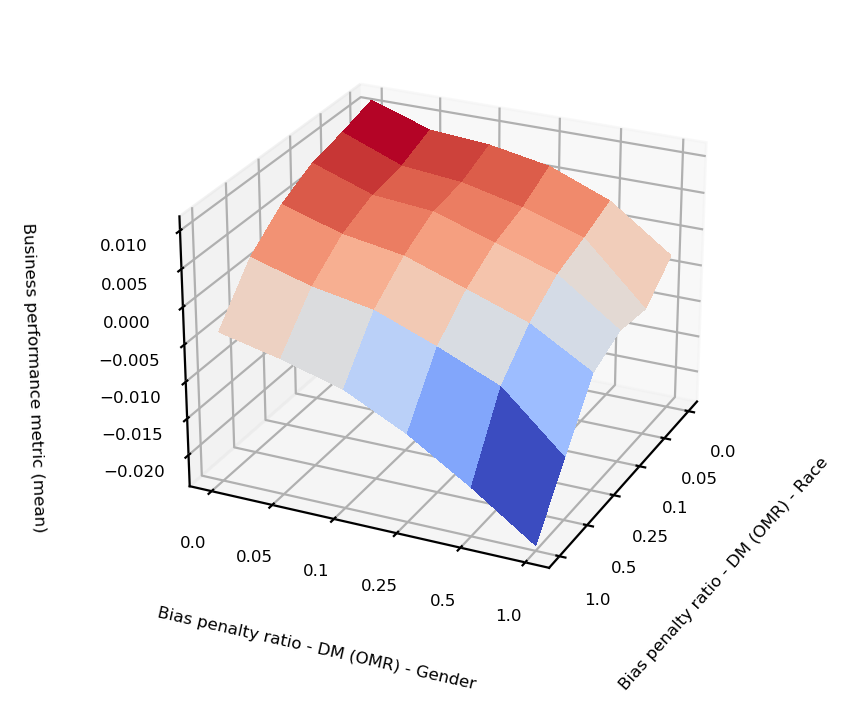

In [275]:
# %matplotlib qt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

X, Y = np.meshgrid(range(6), range(6))

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y, biasGridResultsArray[0,0,1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_xticks([2e-40,2e-38,2e-36,2e-36,2e-34,2e-32,2e-30,2e-28,2e-26])
# ax.set_yticks([2**7,2**8,2**9,2**10,2**11,2**12,2**13])
ax.set_xticks(range(6))
ax.set_yticks(range(6))

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xticklabels([0.0,0.05,0.1,0.25,0.5,1.0],rotation=0)
ax.set_yticklabels([0.0,0.05,0.1,0.25,0.5,1.0],rotation=0)
ax.set_xlabel('Bias penalty ratio - DM (OMR) - Race',rotation=0, labelpad=10,size=6)
ax.set_ylabel('Bias penalty ratio - DM (OMR) - Gender',rotation=0, labelpad=10,size=6)
ax.set_zlabel('Business performance metric (mean)', labelpad=10,size=6)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.view_init(elev=25, azim=25)
# plt.savefig('saved_graphs/20210904_adult_wBias_busPerfMean_test')

In [229]:
# 3-D chart subject to filter

%matplotlib qt
# %matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

now = datetime.now()

axisToFilter = 0
filterMarkers = [0,0.15,0.2,0.25,1]


labelNames = ['lGD=0.00','LGD=1.00']


fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(interimLowVol[:,0],interimLowVol[:,1],interimLowVol[:,2],s=1)
ax.scatter(interimHighVol[:,0],interimHighVol[:,1],interimHighVol[:,2],s=1)

ax.set_xlabel("FPR",labelpad=10,size=6)
ax.set_ylabel("FNR",labelpad=10,size=6)
ax.set_zlabel("DM (OMR) - Gender",labelpad=10,size=6)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,0.2])
ax.view_init(elev=15, azim=-105)
ax.legend(labelNames,fontsize=5) 

# plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_axis"+str(axisToFilter)+"_overall",bbox_inches = 'tight')

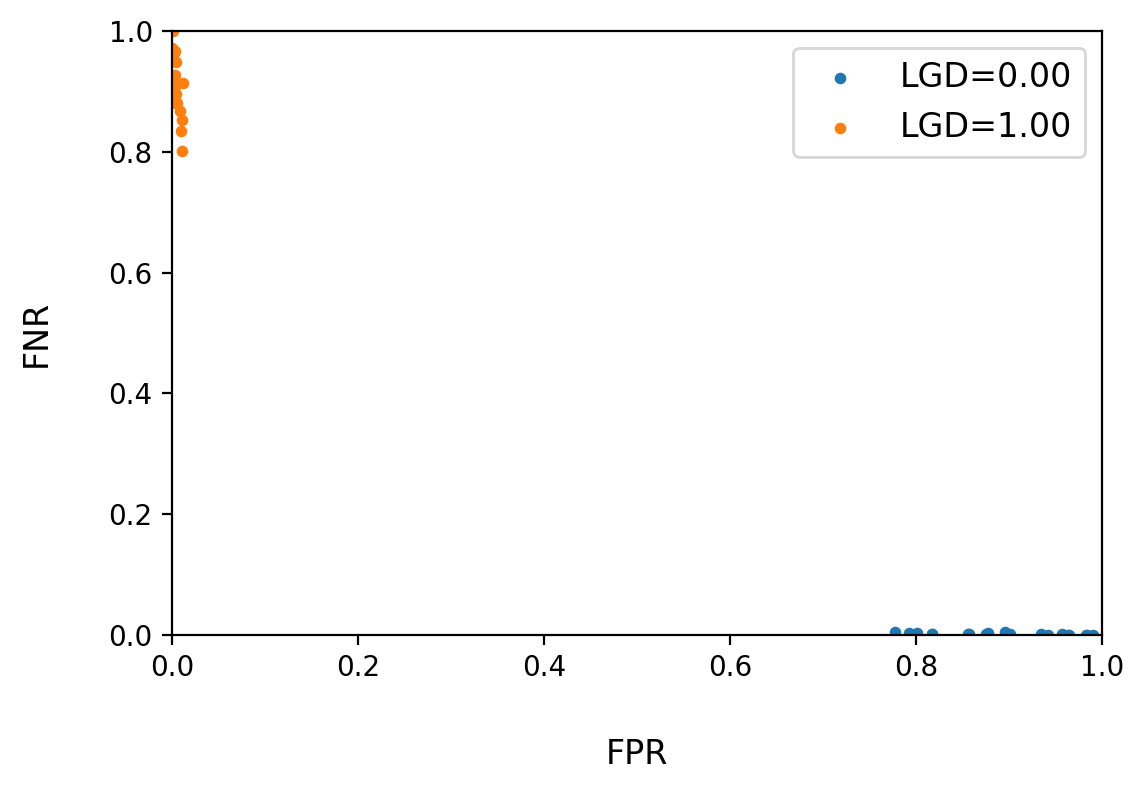

In [236]:
%matplotlib inline
import matplotlib.pyplot as plt

now = datetime.now()
labelNames = ['LGD=0.00','LGD=1.00']

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(interimLowVol[:,0],interimLowVol[:,1],s=10)
ax.scatter(interimHighVol[:,0],interimHighVol[:,1],s=10)
ax.set_xlabel("FPR",labelpad=20,size=12)
ax.set_ylabel("FNR",labelpad=20,size=12)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend(labelNames,fontsize=12) 

# plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_lowHighVol",bbox_inches = 'tight')

In [244]:
spread = 0.2

lgdDict = {}
labelNames = []

for i, lgd in enumerate([0.0,0.05,0.1,0.25,0.5,1.0]):
    lgdDict[i] = computeBestModelValues(trainingAlgoDict, datasetDict, spread, lgd, 0, 0)[:,1:,0]
    labelNames.append('LGD='+str(lgd))

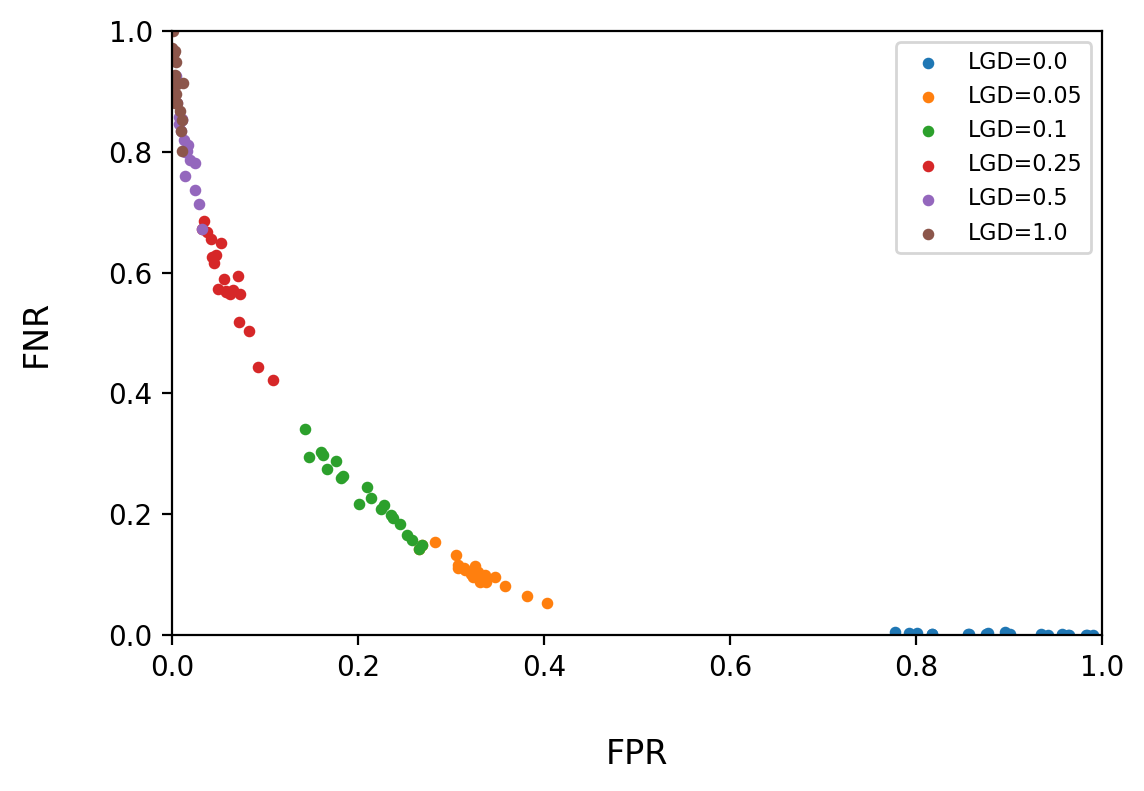

In [248]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)

for i in range(len(lgdDict)):
    ax.scatter(lgdDict[i][:,0],lgdDict[i][:,1],s=10)

ax.set_xlabel("FPR",labelpad=20,size=12)
ax.set_ylabel("FNR",labelpad=20,size=12)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend(labelNames,fontsize=8)

plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_allLGDs",bbox_inches = 'tight')